# Tarea 1: Activaciones y pasada hacia adelante en una red neuronal <br/> CC6204 Deep Learning, Universidad de Chile  <br/> Hoja de respuestas
## Nombre: 
Fecha de entrega: 2 de octubre de *2020*

In [1]:
# Este notebook está pensado para correr en CoLaboratory. 
# Lo único imprescindible por importar es torch 
import torch

# Posiblemenete quieras instalar e importar ipdb para debuggear.
# Si es así, descomenta lo siguiente
# !pip install -q ipdb
# import ipdb

# Aqui instalamos la libreria de correccion del curso
!pip install "git+https://github.com/dccuchile/CC6204.git@master#egg=cc6204&subdirectory=autocorrect"

  Cloning https://github.com/dccuchile/CC6204.git (to revision master) to /tmp/pip-install-yvcu1w2z/cc6204
  Running command git clone -q https://github.com/dccuchile/CC6204.git /tmp/pip-install-yvcu1w2z/cc6204
  Created wheel for cc6204: filename=cc6204-0.2.2-cp36-none-any.whl size=4674 sha256=04010fee3060a6dcfab6775428ec35e1d01a067b425f5b97e88f3c4ae6837b7f
  Stored in directory: /tmp/pip-ephem-wheel-cache-ws953bp3/wheels/62/f0/30/aadcb7ce24a2f9c935890518e902d4e23bf97b80f47bb64414
Successfully built cc6204


In [2]:
# importamos las herramientas del curso
from cc6204 import AutoCorrect, FailedTest

# ingresa el host y port que posteamos en u-cursos

corrector = AutoCorrect(host="cc6204.dcc.uchile.cl", port=443)

# anota el token que te daremos en u-cursos

token = "]ye/Ox;nsz"

Connection stablished


# Parte 1: Funciones de activación y función de salida

## 1a) Funciones de activación

In [103]:
def sig(T):
  return torch.reciprocal(1 + torch.exp(-1 * T))

def tanh(T):
  E = torch.exp(T)
  e = torch.exp(-1 * T)
  return (E - e) * torch.reciprocal(E + e)

# Tu código acá
def relu(T):
  zeros=T*0                 #construmimos arreglo auxiliar usando T para que esten en el mismo device
  return torch.max(T,zeros) #se devuelve el maximo entre T y 0, esto lo hace componente a componente por lo que hace lo pedido

def swish(T, beta ):
  return torch.mul(T,sig(T*beta)) #se multiplica componente a componente T con sigmoid(T*beta) que es lo que hace swish

def celu(T, alfa):
  pos= (T>=0)*1 #se crea un arreglo con unos donde la componente de T es mayor o igual que 0, cero en todo el resto
  neg= (T<0)*1 #se crea un arreglo con unos donde la componente de T es menor a 0, cero en todo el resto
  return torch.add(torch.mul(T,pos),torch.mul(alfa*(torch.sub(torch.exp(T/alfa),1)),neg))
  #usando los arreglo neg y pos se logra ver que componentes de T deben mostrar T (donde T es >=0) y donde deben mostrar 
  #alfa*exp((T/alfa)-1) (donde T es <0)

In [104]:
# correccion
test_relu = corrector.get_test_data(homework=1, question="1a", test=1, token=token)
test_swish, swish_par = corrector.get_test_data(homework=1, question="1a", test=2, token=token)
test_celu, celu_par = corrector.get_test_data(homework=1, question="1a", test=3, token=token)
#test se pasan de listas a tensores
test_relu = torch.tensor(test_relu)
test_swish = torch.tensor(test_swish)
test_celu = torch.tensor(test_celu)

corrector.sumbit(homework=1, question="1a", test=1, token=token, answer=relu(test_relu))
corrector.sumbit(homework=1, question="1a", test=2, token=token, answer=swish(test_swish, swish_par))
corrector.sumbit(homework=1, question="1a", test=3, token=token, answer=celu(test_celu, celu_par))

Using cached test data
Using cached test data
Using cached test data
Correct Test!
Correct Test!
Correct Test!


## 1b) Softmax

**Demostracion:**

Sea $X$=($x_{1}$,$x_{2}$,...,$x_{n}$), $X^{'}$=($x_{1}-M$,$x_{2}-M$,...,$x_{n}-M$), entonces:

softmax($X$)=($s_{1}$,$s_{2}$,...,$s_{n}$), donde $s_{i}$=$\frac{e^{x_{i}}}{\sum_{j=1}^{n}e^{x_{j}}}$, con $i=1,...,n$

Luego, softmax($X^{'}$)=($s_{1}^{'}$,$s_{2}^{'}$,...,$s_{n}^{'}$), donde $s_{i}^{´}$=$\frac{e^{x_{i}-M}}{\sum_{j=1}^{n}e^{x_{j}-M}}$, 

pero $e^{x_{i}-M}$ = $e^{x_{i}}*e^{-M}$ y tambien ${\sum_{j=1}^{n}e^{x_{j}-M}}$ =${\sum_{j=1}^{n}e^{x_{i}}*e^{-M}$=$e^{-M}*\sum_{j=1}^{n}e^{x_{j}}}$

Por lo tanto  $s_{i}^{´}$=$\frac{e^{x_{i}-M}}{\sum_{j=1}^{n}e^{x_{j}-M}}$ = $\frac{e^{-M}*e^{x_{i}}}{e^{-M}*\sum_{j=1}^{n}e^{x_{j}}}$=$\frac{e^{x_{i}}}{\sum_{j=1}^{n}e^{x_{j}}}$=$s_{i}$, esto para todo $i=1,...,n$.

Con lo cual, se llega a que sorfmax($X^{'}$)=softmax($X$)


In [105]:
# Tu código acá

def softmax(T, dim, estable=True):
  if estable:                                #esto es que queremos restar el mismo valor por cada componente de la dimension dim
    aux=torch.max(T,dim=dim,keepdim=True)[0] #aqui construimos un arreglo auxiliar con las "mismas dimensiones" que T 
    aux=torch.exp(torch.sub(T,aux))          #(tiene un 1 en la dimension dim) y guarda los maximos por componente en esa dimension de T
                                             #luego se le resta ese maximo a cada componente (siempre a la correspondiente) y saca exp
  else:                                      #estable=false, por lo que no restamos nada
    aux=torch.exp(T)                         #solo tomamos exp
  return torch.div(aux,torch.sum(aux,dim,keepdim=True))  #devolvemos la division entre la componente y la suma en dicha dimension

In [106]:
test_softmax, _dim = corrector.get_test_data(homework=1, question="1b", test=1, token=token)
test_softmax = torch.tensor(test_softmax)
corrector.sumbit(homework=1, question="1b", test=1, token=token, answer=softmax(test_softmax, dim=_dim))

Using cached test data
Correct Test!


# Parte 2: Red neuronal y pasada hacia adelante (forward)

## 2a) Clase para red neuronal, 2b) Iterando por parametros, 2d) Pasada hacia adelante

In [108]:
# Tu código debiera continuar así 

class FFNN(torch.nn.Module):
  def __init__(self, F, l_h, l_a, C):
    super(FFNN, self).__init__()
    #pasamos todos los parametros a torch.nn.Parameter(), y definimos las variables de los parametros (pesos) y los sesgos de la red
    self.F=torch.nn.Parameter(torch.Tensor([F]))
    self.l_h=torch.nn.Parameter(torch.Tensor(l_h))
    self.l_a=l_a
    self.C=torch.nn.Parameter(torch.Tensor([C]))
    self.parametros=None
    self.sesgos=None
  
  def setParameters(self,W,b,U,c):
    #incializamos o modificamos los parametros y sesgos de la red, juntamos W con U y b con c
    self.parametros=torch.nn.ParameterList([torch.nn.Parameter(W[i]) for i in range(len(W))]+[torch.nn.Parameter(U)])
    self.sesgos=torch.nn.ParameterList([torch.nn.Parameter(b[i]) for i in range(len(b))]+[torch.nn.Parameter(c)])

  def resumen(self):
    # Usa self.named_parameters(). y retorna todos los parametros reconocidos de la neurona
    for param in self.named_parameters():
      print(param)
      pass
  
  def forward(self, x):
    # Usa los parámetros y funciones de activación.
    # Retorna y = softmax(capa_de_salida).
    h=self.l_a[0](torch.add(torch.mm(x,self.parametros[0]),self.sesgos[0]))     #inicializamos h con (la primera multiplicacion entre x y W1) + b1
    for i in range(1,len(self.sesgos)-1):                                       #recorremos todos los parametros (todas las matrices de peso), excepto la ultima
      h=self.l_a[i](torch.add(torch.mm(h,self.parametros[i]),self.sesgos[i]))   #redefinimos h como vimos en clases
    return softmax(torch.add(torch.mm(h,self.parametros[-1]),self.sesgos[-1]),1)#devolvemos softmax de los predicho por nuestra red (y)

## 2c) Moviendo los parámetros entre dispositivos

In [109]:
#Probamos que nuestros parametros esten bien definidos en nuestra red, al no inicializar los parametros y los sesgos no se consume mucha ram
redes_neuronales= FFNN(100000,[5000,3000,4000,20000],[relu,sig,relu,relu],100)
torch.cuda.empty_cache() 
!nvidia-smi
redes_neuronales.cuda()
!nvidia-smi

Sun Sep 27 22:39:35 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    28W /  70W |    899MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Parte 3: Probando tu red con parámetros pre-entrenados para MNIST

In [110]:
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
from random import randint

# Descarga y almacena el conjunto de prueba de MNIST.
dataset = MNIST('mnist', train=False, transform=ToTensor(), download=True)
print('Cantidad total de datos:',len(dataset))

Cantidad total de datos: 10000


## 3b) Cargando los parámetros pre-entrenados

In [ ]:
#descargamos los parametros y sesgos ya entrenados
!wget -O U.txt https://raw.githubusercontent.com/dccuchile/CC6204/master/2020/tareas/tarea1/mnist_weights/U.txt
!wget -O W1.txt https://raw.githubusercontent.com/dccuchile/CC6204/master/2020/tareas/tarea1/mnist_weights/W1.txt
!wget -O W2.txt https://raw.githubusercontent.com/dccuchile/CC6204/master/2020/tareas/tarea1/mnist_weights/W2.txt
!wget -O b1.txt https://raw.githubusercontent.com/dccuchile/CC6204/master/2020/tareas/tarea1/mnist_weights/b1.txt
!wget -O b2.txt https://raw.githubusercontent.com/dccuchile/CC6204/master/2020/tareas/tarea1/mnist_weights/b2.txt
!wget -O c.txt https://raw.githubusercontent.com/dccuchile/CC6204/master/2020/tareas/tarea1/mnist_weights/c.txt

In [111]:
from numpy import loadtxt
#guardamos los parametros en variables para poder utilizarlos
U = torch.from_numpy(loadtxt('U.txt')).float()
W1 = torch.from_numpy(loadtxt('W1.txt')).float()
W2 = torch.from_numpy(loadtxt('W2.txt')).float()
b1 = torch.from_numpy(loadtxt('b1.txt')).float()
b2 = torch.from_numpy(loadtxt('b2.txt')).float()
c = torch.from_numpy(loadtxt('c.txt')).float()

In [50]:
#creamos nuestra red neuronal con la arquitectura dicha en el enunciado
red_neuronal=FFNN(784,[32,16],[relu,relu],10)
#cargamos los parametros y sesgos ya entrenados a la red
red_neuronal.setParameters([W1,W2],[b1,b2],U,c)

## 3c) Cálcula la predicción de un ejemplo al azar

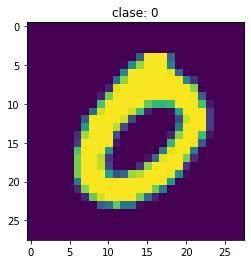

tensor([0])


In [112]:
import random
index = random.randint(0,len(dataset))               #obtenemos imagen al azar del dataset
T, l = dataset[index]                                #guardamos el vector de features (T) y su categoria (l)
numero = T.view(28,28).numpy()                       #modificamos la imagen para plotearla mas facil
fig1 = plt.imshow(numero)                            #plot de la imagen
plt.title("clase: "+ str(l))                         #titulo de la imagen
plt.show()
print(red_neuronal.forward(T.view(1,784)).argmax(1)) #printeamos el resultado predicho por nuestra red (aveces se equivoca)

## 3d) Pasando todos los ejemplos por la red con un `DataLoader`

In [115]:
# Acá tu código
from torch.utils.data import DataLoader
def calcula_acierto(red, dataset, batch_size=100, device='cuda'):
  dataloader=DataLoader(dataset,batch_size)                           #cargamos los datos en paquetes
  aciertos=0                                                          #incializamos lo que devolveremos
  red=red.to(device)                                                  #pasamos toda la red al device ingresado
  for x,y in dataloader:                                              #recorremos por paquetes nuestro dataset
    x=x.to(device)                                                    #pasamos x al device ingresado
    y=y.to(device)                                                    #pasamos y al device ingresado
    y_gorro=red.forward(x.view(batch_size,-1)).argmax(1)              #modificamos x para que calce en nuestra red y guardamos la prediccion
    aciertos += ((torch.sum((y_gorro==y.view(batch_size))*1))).item() #guardamos el numero de aciertos
  return aciertos/len(dataset)                                     #obtemos el porcentaje de aciertos dividiendo el obtenido por el total

In [116]:
print(calcula_acierto(red_neuronal,dataset,10000,'cuda'))

0.9612


In [117]:
print(calcula_acierto(red_neuronal,dataset,10000,'cpu'))

0.9612


### Correccion red

In [118]:
from torch.utils.data import Subset
indices = corrector.get_test_data(homework=1, question="network", test=1, token=token)
test_set = Subset(dataset, indices)

Using cached test data


In [119]:
red = red_neuronal.to('cuda')                  #se define la red y se pasa a cuda
dataloader=DataLoader(test_set,50)             #se carga el test_set en paquetes de 50 ejemplos (es solo 1)
y_gorro=torch.Tensor([])                       #se inicializa el vector de prediccion
for x,y in dataloader:                         #se hace for para generalizar y poder probar con otros datasets
  x=x.to('cuda')                               #se pasa x a cuda
  y_gorro=torch.cat((y_gorro,(red.forward(x.view(50,-1)).argmax(1).to('cpu')).view(50)),0) #se calcula prediccion y se juntan en un vector
result = y_gorro                               #se guarda la prediccion en la variable result
print(calcula_acierto(red,test_set,25,'cuda')) #se ve "precision" de la red para el test_set

corrector.sumbit(homework=1, question="network", test=1, token=token, answer=result)

0.0
Correct Test!


## 3e) Opcional: Muestra los casos en donde la red se equivoca

In [ ]:
# Acá tu código

## 3d) Opcional: Crea tus propios ejemplos de dígitos para clasificar

In [ ]:
# Acá tu código